In [248]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import sklearn.cross_validation as cv
import sklearn.feature_extraction as fe
import sklearn.metrics as mert

import pymongo

import matplotlib.pyplot as plt
%matplotlib inline


client = pymongo.MongoClient('mongodb://donkey:27017/')
db = client.sphere_kaggle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
db.collection_names()

[u'debug',
 u'errors',
 u'results',
 u'system.indexes',
 u'test',
 u'test_hashtag_data',
 u'test_text_data',
 u'test_tweets',
 u'train_hashtag_data',
 u'train_text_data',
 u'train_tweets',
 u'train_tweets_tmp',
 u'tweets',
 u'unrecognized_locations',
 u'users',
 u'vocabulary',
 u'words_log_probs']

# 1. Подготовим данные

In [45]:
def twitter_mongo2pandas(collection):
    db_df = pd.DataFrame(list(collection.find()))
    db_df = db_df.drop('_id', axis=1)
    db_df.index = db_df.twitter_id
    
    df = db_df.drop('twitter_id', axis=1)
    return df

#### Создадим православную training выборку из имеющихся данных
#### twitter_id, label

In [46]:
train_users_ids_with_tweets = db.train_tweets.distinct("user.id")
labels = db.users.distinct("label")

In [47]:
dfs = []

for label in labels:
    labeled_users_ids = db.users.distinct("id", {"id": {"$in": train_users_ids_with_tweets},
                                                 "label": label})
    df = pd.DataFrame(index=labeled_users_ids)
    df["label"] = label
    dfs.append(df)
    
train_df = pd.concat(dfs)
train_df.index.name = "twitter_id"

In [48]:
train_df.label.value_counts()

1    1136
3    1110
2     437
dtype: int64

In [64]:
train_df.head()

,label
twitter_id,
2182641,1
9699312,1
10485842,1
10540152,1
10915772,1


Создадим два варианта данных:
- просто текст
- только теги

**collection: train_text_data**

In [49]:
db.train_text_data.find_one()

{u'_id': ObjectId('56758a599443b074326c4941'),
 u'label': 1,
 u'text': u'grin devilish abrazenbeaut ladi whisper quick love baesprincess baesbonehead stab joffrey mother #newavi seen ravish ladi brienn baesprincess badkingslay chain ladi baesprincess think time baesprincess get season three warm #ff love twin twisted_twin_ #ff love twin twisted_twin_ #wcw twisted_twin_ #ff scari beauti twin twisted_twin_ #womancrushwednesday beauti twin twisted_twin_ #twintuesday happi one onli twisted_twin_ #ff love sister twisted_twin_ #writerwednesday meh look last week #womancrushwednesday better half twisted_twin_ #twintuesday happi wonder twin twisted_twin_ #seductivesunday love lioness twisted_twin_ stump #ff dear sweet sister twisted_twin_ #ff account word mother actual_cersei #ff nephew yes nephew jofftheillborn #ff better half sheroarsloud goodnight westero thank follow littl friend head ship multipl cersei new account new retweet would appreci',
 u'twitter_id': 2645443011L}

In [50]:
len(db.train_text_data.distinct("twitter_id"))

2684

In [51]:
train_text_df = twitter_mongo2pandas(db.train_text_data) # get_train_text_df()

In [52]:
train_text_df[:2]

,label,text
twitter_id,,
2645443011,1,grin devilish abrazenbeaut ladi whisper quick ...
312928916,2,#e3ong4 gearscan deliv time multiplay add hoar...


In [53]:
train_text_df = train_text_df[train_text_df.label.notnull()]

**collection: test_text_data**

In [54]:
test_text_df = twitter_mongo2pandas(db.test_text_data)# get_test_text_df()

In [55]:
test_text_df[:2]

,text
twitter_id,
269247809,tweetdeck today real pain know show damn tweet...
156790994,aight gone foo yall easi need dalla emoji trip...


**collection: train_hashtag_data**

In [56]:
db.test_hashtag_data.find_one()

{u'_id': ObjectId('567679189443b01291252289'),
 u'text': u'#finalsweek #h2p #h2p #goat #h2p #channel21 #h2p #channel21 #good #morning #h2p #h2p #teamrousey #ufc193 #h2p #4 #randomthought #madnessiscoming #tonight #10pm #madnessiscoming #wiz #nightcrawler #5god #rp #darknessisspreading #levels #words2liveby #words2die2 #words2liveby #yeezus2020 #glizzygang #newday #uncommonsense #rocketpower #tito #90skid #5god #channel21 #rp #wowwednesday #mustbethemoney #primetime #goat #weezywednesday #weezywednesdays #message #baddestwomanontheplanet #sexy #h2p #channel21 #tunein #back2back #waitaminute #backtoback #happybirthday2me #i #idareyou #idoubledare #channel21 #truth #heatnation #godmoneywar #dubnation #getiggywithit #theigniter #yeezusseason #dubnation #flyhighdai #dubnation #dubnation #h2p #freshprince #onrepeat #1stteam #teampacquiao #truth #truth #kdot #supahotfire #supahotfire #supahotfire #taan #wrestlemania #wrestlemania #psu #h2p #h2p #wweraw #piaa #empire #empire #h2p #10thseed #ww

In [57]:
test_hashtag_df = twitter_mongo2pandas(db.test_hashtag_data) #get_test_hashtag_df()

In [58]:
test_hashtag_df[:2]

,text
twitter_id,
230635591,#finalsweek #h2p #h2p #goat #h2p #channel21 #h...
2239578338,#growingupinasmalltown #growingupshy #wcw #fir...


**collection: train_hashtag_data**

In [59]:
db.train_hashtag_data.find_one()

{u'_id': ObjectId('567679089443b0126d4195cd'),
 u'label': 2,
 u'text': u'#livingthedream #gopack #marchmadness #physicsclass #np #gopack #wpn #dancing #oompaloompastatus #np #bookstacksfloor7 #terminatethetarheels #gopack #gottagetmeone #gopack #definitelyakeeper #packpride #champion #spent #gopack #omahabound #gopack #omahabound #gopack #wpn #gopack #bestgfever #ncpride #gopack #np #gopack #catsrock #fatheroftheyear #gobacktojersey #scrubs #apcalcexam #somanypeople #thanksbabe #awfulcall #stupid #ignorant #why #wolfpack #ncsu #beyondexcited #gopack #freedeangelo #prom #clutch #ninja #beatleesville #enloebaseball #sorawwelosealot #pissed #np #tarholes #gopack #gopack #bringitontarholes #gopack #omahabound #goaway #rainisagoodthing #np #soanxious #letmein #pleaseacceptme #seniors #pissed #joshturner #np #gopack #stop #mericamonday #merica #fuckanyothercountryincludingcanada #getouttahere #seniors #jealous #word #scrub #getouttahere #14 #classy #actlikeyouvebeenthere #seniors #whatareyou

In [60]:
train_hashtag_df = twitter_mongo2pandas(db.train_hashtag_data)

In [61]:
train_hashtag_df[:2]

,label,text
twitter_id,,
401845670,2,#livingthedream #gopack #marchmadness #physics...
29671057,3,#liesyoushouldntfallfor #wheniwasakid #onethin...


In [62]:
train_hashtag_df = train_hashtag_df[train_hashtag_df.label.notnull()]

# На выходе:
- train_text_df / test_text_df
- train_hashtag_df / test_hashtag_df
- train_df

# 2. Эксперименты

In [207]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import naive_bayes, linear_model

In [208]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.grid_search import GridSearchCV

In [209]:
vocabulary = db.vocabulary.find_one({"_id": "vocabulary"})["vocabulary"]
len(vocabulary)

300

In [232]:
default_pipe = [
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
]

default_params = {
#     'vect__binary': (True, False),
    'vect__max_features': (5000, 50000),
#     'tfidf__norm': (None, 'l1', 'l2'),
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'tfidf__sublinear_tf': (True),
}


model_MultinomialNB = {
    'clf': Pipeline(default_pipe + [('clf', naive_bayes.MultinomialNB())]),
    'params': dict(default_params, **{
#             'clf__alpha': (1e-1, 1e-2, 1e-3),
            'clf__fit_prior': (True, False),
        })
}


model_SGDClassifier = {
    'clf': Pipeline(default_pipe + [('clf', linear_model.SGDClassifier())]),
    'params': dict(default_params, **{
            'clf__loss': ('log'),
            'clf__penalty': ('l1'),
            'clf__alpha': (1e-2, 1e-4),
            'clf__n_iter': (5),
            'clf__random_state': (42),
        })
}


model_LogisticRegression = {
    'clf': Pipeline(default_pipe + [('clf', linear_model.LogisticRegression())]),
    'params': dict(default_params, **{
            'clf__solver': ('lbfgs'),
            'clf__multi_class': ('ovr'),
            'clf__class_weight': ('auto')
        })
}

# http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss
# http://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html


In [233]:
def check_model(data_df, model):
    X = data_df.text.as_matrix()
    y = data_df.label.as_matrix().astype(np.int16)
    
    gs_clf = GridSearchCV(model.get("clf"),
                          model.get("params"),
                          cv=5,
                          scoring="log_loss",
                          n_jobs=-1)
    gs_clf = gs_clf.fit(X, y)
    
    return gs_clf

In [250]:
gs = check_model(train_text_df, model_MultinomialNB)

(-2.8829289741097104, -0.79951716740389955)

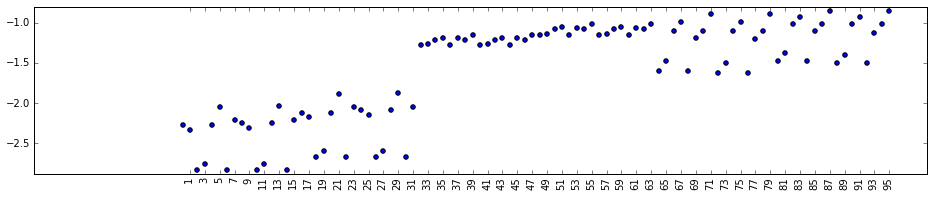

In [251]:
plt.figure(figsize=(16, 3))
means = [gs.grid_scores_[i].mean_validation_score for i in range(len(gs.grid_scores_))]
plt.scatter(range(len(gs.grid_scores_)), means)
plt.xticks(range(1, len(gs.grid_scores_), 2), rotation='vertical');
plt.ylim([min(means)-0.05, max(means)+0.05])

In [253]:
gs.best_score_

-0.8495171674038996

In [244]:
gs.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...e,
         use_idf=False)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=False))])

In [246]:
def make_submission(test_df, clf):
    X_test = test_df.text
    y_pred = clf.predict_proba(X_test)
    
    test_final = pd.DataFrame(y_pred)
    test_final.index = test_df.index
    test_final.columns = ["is_1", "is_2", "is_3"]
    
    twitter_submission_df = pd.read_csv("./twitter_submission.csv", index_col="twitter_id")
    
    no_pred_ids = set(twitter_submission_df.index) - set(test_final.index)
    
    final_df = pd.concat([test_final, twitter_submission_df.loc[list(no_pred_ids)]])
    
    final_df.to_csv("./my_submission.csv")
    
    return final_df

In [247]:
make_submission(test_text_df, gs.best_estimator_)

,is_1,is_2,is_3
twitter_id,,,
269247809,0.062920,0.038136,0.898944
156790994,0.562940,0.153247,0.283813
40366130,0.462563,0.114370,0.423067
362152133,0.982398,0.007588,0.010014
1011643310,0.428169,0.096263,0.475568
2543890665,0.535016,0.099074,0.365910
230635591,0.470697,0.299733,0.229570
2239578338,0.567725,0.148372,0.283902
1143641238,0.446639,0.379295,0.174066


In [ ]:
ma

In [198]:
X_train = train_df.text.as_matrix()
y_train = train_df.label.as_matrix().astype(np.int16)
X_test = test_df.text.as_matrix()
y_test = test_df.label.as_matrix().astype(np.int16)

In [199]:
gs_clf = GridSearchCV(text_clf, parameters,
                      scoring="logloss",
                      n_jobs=-1)

In [201]:
gs_clf = gs_clf.fit(X, y)
gs_clf.best_score_

0.55124860231084605

In [188]:
def experiment1(train_df, test_df, pipeline):
#     train_df, test_df = cv.train_test_split(train_hashtag_df, test_size = 0.33)
    print train_df.label.value_counts()
    
    X_train = train_df.text.as_matrix()
    y_train = train_df.label.as_matrix().astype(np.int16)
    X_test = test_df.text.as_matrix()
    y_test = test_df.label.as_matrix().astype(np.int16)
    
    text_clf = pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict_proba(X_test)
    return log_loss(y_test, y_pred)


In [189]:
experiment1(train_df, test_df, p)

1    751
3    741
2    305
dtype: int64


NameError: global name 'log_loss' is not defined

# TD-IFD для train_text_df

In [109]:
train_text_df.text[:10]

twitter_id
2645443011    grin devilish abrazenbeaut ladi whisper quick ...
312928916     #e3ong4 gearscan deliv time multiplay add hoar...
629509696     new fanfic black box formul secret rendezv bbt...
2871001972    wait see master next seri #doctorwho satan pit...
1028323638    ask question ask question home sick shouldn mu...
3023454748    senior work need get seen josh teddi play veri...
140086848     hope put collect neilhimself issu togeth reall...
401845670     recent accept turfgrass scienc program north c...
29671057      whi everyon bore day look peopl face rap price...
1868456832    knew happiest pictur could also becom pain ive...
Name: text, dtype: object

In [115]:
tf1 = fe.text.TfidfVectorizer()
data = tf1.fit_transform(train_text_df.text)

In [121]:
data.toarray().shape

(2684, 333225)

In [120]:
tf1.get_feature_names().index("sheldon")

260590

In [122]:
np.sum(data.toarray()

array([ 0.        ,  0.        ,  0.26414847, ...,  0.        ,
        0.        ,  0.00826463])

In [127]:
sum_over_data = np.sum(data.toarray(), axis=1)

In [142]:
np.argsort(sum_over_data)[:10]

array([ 647, 1736,  448, 2331, 1372, 1324, 1966, 1356, 1403, 2368])

# TD-IFD для train_hashtag_df

In [242]:
cv_train_hashtag_df, cv_test_hashtag_df = cv.train_test_split(train_hashtag_df, test_size = 0.33)

In [243]:
cv_train_hashtag_df.head()

,label,text
twitter_id,,
394169598,3,#thetruth #airmaxday #nosew95 #nrml #luckychar...
51119725,3,#fatclub #ouch #uxcampyeg #rage #undo #bbcf1 #...
2450140638,3,#bo #bobsburgers #genebelcher #eugenem #bobsbu...
730218384,2,#explainafilmplotbadly #13seconds #johnlewisdo...
83997957,3,#yelp #yelp #yelp #yelp #yelp #yelp #yelp #yel...


In [244]:
tfidf = fe.text.TfidfVectorizer(smooth_idf=True)
X_train = tfidf.fit_transform(cv_train_hashtag_df.text).toarray()
y_train = cv_train_hashtag_df.label.as_matrix()

X_test = tfidf.transform(cv_test_hashtag_df.text).toarray()
y_test = cv_test_hashtag_df.label.as_matrix()

In [246]:
# from sklearn import svm
from sklearn import naive_bayes #MultinomialNB

In [247]:
clf = naive_bayes.MultinomialNB()

In [248]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [261]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [262]:
from sklearn.pipeline import Pipeline


In [263]:
X_train = cv_train_hashtag_df.text.as_matrix()
y_train = cv_train_hashtag_df.label.as_matrix().astype(np.int16)
X_test = cv_test_hashtag_df.text.as_matrix()
y_test = cv_test_hashtag_df.label.as_matrix().astype(np.int16)

In [264]:
hashtag_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])


In [265]:
hashtag_clf = text_clf.fit(X_train, y_train)

In [266]:
y_pred = hashtag_clf.predict(X_test)

In [267]:
from sklearn.metrics import classification_report

In [268]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.51      0.75      0.60       377
          2       1.00      0.02      0.04       137
          3       0.60      0.53      0.56       372

avg / total       0.62      0.54      0.50       886



# TD-IFD для train_text_df


In [74]:
vocabulary = db.vocabulary.find_one({"_id": "vocabulary"})["vocabulary"]

In [962]:
len(vocabulary)

300

In [963]:
cv_train_text_df, cv_test_text_df = cv.train_test_split(train_text_df, test_size = 0.33)

In [964]:
X_train = cv_train_text_df.text.as_matrix()
y_train = cv_train_text_df.label.as_matrix().astype(np.int16)
X_test = cv_test_text_df.text.as_matrix()
y_test = cv_test_text_df.label.as_matrix().astype(np.int16)

In [965]:
np.unique(y_train)

array([1, 2, 3], dtype=int16)

In [1025]:
from sklearn import naive_bayes
from sklearn.metrics import log_loss

In [1039]:
vocabulary = db.vocabulary.find_one({"_id": "vocabulary"})["vocabulary"]
print len(vocabulary)
text_clf = Pipeline([#('vect', CountVectorizer(vocabulary=vocabulary)),
                     #('tfidf', TfidfTransformer()),
                     ('tfidf', TfidfVectorizer(vocabulary=vocabulary, sublinear_tf=True)),
                     ('clf', naive_bayes.MultinomialNB(alpha=0.1, fit_prior=True)),
])

text_clf1 = Pipeline([#('vect', CountVectorizer(vocabulary=vocabulary)),
                     #('tfidf', TfidfTransformer()),
                     ('tfidf', TfidfVectorizer(vocabulary=vocabulary, sublinear_tf=True)),
                     ('clf', LogisticRegression(solver='lbfgs', multi_class='ovr', class_weight='auto')),
])

text_clf = Pipeline([#('vect', CountVectorizer(vocabulary=vocabulary)),
                     #('tfidf', TfidfTransformer(sublinear_tf=True)),
                     ('tfidf', TfidfVectorizer(vocabulary=vocabulary, sublinear_tf=True)),
                     ('clf', SGDClassifier(loss='log', penalty='l1', 
                                           alpha=1e-4, n_iter=10, random_state=42)),
])
text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict_proba(X_test)
log_loss(y_test, y_pred)

6000


0.70649526362613102

In [1024]:
log_loss(y_test, y_pred)

6.9098267156203068

<bound method Pipeline.get_params of Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])>

In [290]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.43      1.00      0.60       357
          2       0.00      0.00      0.00       142
          3       0.95      0.14      0.25       387

avg / total       0.59      0.46      0.35       886



In [358]:
from sklearn.linear_model import SGDClassifier
log_loss(y_test, y_pred)

In [359]:
text_clf = Pipeline([('vect', CountVectorizer(vocabulary=db.vocabulary.find_one({"_id": "vocabulary"})["vocabulary"])),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])
_ = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
np.mean(y_pred == y_test)    

0.64785553047404065

In [279]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.59      0.83      0.69       369
          2       0.79      0.11      0.19       137
          3       0.66      0.61      0.63       380

avg / total       0.65      0.62      0.59       886



In [69]:
train, test = cv.train_test_split(train_df, test_size = 0.33)

In [70]:
train.label.value_counts()

1    759
3    752
2    286
dtype: int64

In [71]:
test.label.value_counts()

1    377
3    358
2    151
dtype: int64

## Теперь добавим в twitter_id, label

# С моим словаряем

In [481]:
cv_train_text_df, cv_test_text_df = cv.train_test_split(train_text_df, test_size = 0.33)

In [482]:
vocabulary = db.vocabulary.find_one({"_id": "vocabulary"})["vocabulary"]

In [491]:
len(vocabulary)

15000

In [483]:
from sklearn.linear_model import LogisticRegression

In [484]:
vect = TfidfVectorizer(vocabulary=vocabulary, sublinear_tf=True)

In [485]:
X_train = vect.fit_transform(cv_train_text_df.text)
y_train = cv_train_text_df.label.as_matrix()

X_test = vect.fit_transform(cv_test_text_df.text)
y_test = cv_test_text_df.label.as_matrix()

In [486]:
# clf = MultinomialNB()
clf = LogisticRegression(solver='lbfgs', multi_class='ovr', class_weight='auto')
clf.fit(X_train, y_train)

# newton-cg’ and ‘lbfgs’

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)

In [487]:
y_pred = clf.predict_proba(X_test)

In [488]:
from sklearn.metrics import log_loss

In [489]:
log_loss(y_test, y_pred)

0.84505046820380458

# Final

In [851]:
X_train = vect.fit_transform(train_text_df.text)
y_train = train_text_df.label.as_matrix()
X_test = vect.fit_transform(test_text_df.text)

In [462]:
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', class_weight='auto')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)

In [ ]:
text_clf = Pipeline([#('vect', CountVectorizer(vocabulary=vocabulary)),
                     #('tfidf', TfidfTransformer()),
                     ('tfidf', TfidfVectorizer(vocabulary=vocabulary, sublinear_tf=True)),
                     ('clf', LogisticRegression(solver='lbfgs', multi_class='ovr', class_weight='auto')),
])

In [ ]:
text_clf.fit(X_train, y_train)

In [478]:
y_pred = text_clf.predict_proba(X_test)

In [479]:
y_pred

array([[ 0.12433036,  0.26249319,  0.61317645],
       [ 0.31974375,  0.35231483,  0.32794142],
       [ 0.29106244,  0.43561733,  0.27332024],
       ..., 
       [ 0.29162049,  0.38952946,  0.31885005],
       [ 0.39506118,  0.25557679,  0.34936203],
       [ 0.37549014,  0.28674225,  0.33776762]])

In [473]:
test_final = pd.DataFrame(y_pred)
test_final.index = test_text_df.index

In [465]:
test_final.index = test_text_df.index

In [469]:
test_final.to_csv("./submission.csv")

In [306]:
Tfidf_with_vocab = TfidfVectorizer(vocabulary=vocabulary)

In [447]:
X_train = Tfidf_with_vocab.fit_transform(cv_train_text_df.text).toarray()
y_train = cv_train_text_df.label.as_matrix()

X_test = Tfidf_with_vocab.transform(cv_test_text_df.text).toarray()
y_test = cv_test_text_df.label.as_matrix()

In [318]:
clf = MultinomialNB()

In [319]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [320]:
y_pred = clf.predict_proba(X_test)

In [321]:
np.mean(y_test == y_pred)

/Users/kopbob/.pyenv/versions/sphere-env-2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise comparison failed; this will raise the error in the future.
  if __name__ == '__main__':


0.0

(1797, 3000)

In [439]:
db.test_text_data.find_one()

{u'_id': ObjectId('56758b239443b078aedf1944'),
 u'text': u'tweetdeck today real pain know show damn tweet ind timelin plea sheldon home think watch babylon train think plea see worri definet contact hundr fifti buck new glass thank god lactos intoler doesn cost ani money shop new glass mayb color instead usual black one cours consequ cours get email bed sheldon know happen yawn public three dimension chess game depend luck cheat win logic caus winner play right way wanna play tic tac toe care turn wopr still think might becom prototyp futur termin happen strike first weapon know italian night could forget keep remind seven year wonder closewil make way past kill sarah connor howard probabl pick raj sometim movement life like forget real boy yeah sometim wonder brain sometim find quit recov saidyear high school dure sheldon way return star war sheet yet year high school still nerd tabl exist record come guinea pig hand might even true misadventur everyhour right wait mean misadventur pr

In [441]:
test_df = pd.DataFrame(list(db.test_text_data.find()))

In [444]:
def get_test_text_df():
    collection = db.test_text_data
    
    train_db_df = pd.DataFrame(list(collection.find()))
    train_db_df = train_db_df.drop('_id', axis=1)
    train_db_df.index = train_db_df.twitter_id
    train_df = train_db_df.drop('twitter_id', axis=1)
    
    return train_df

In [445]:
test_df = get_test_text_df()

In [446]:
test_df.head()

,text
twitter_id,
269247809,tweetdeck today real pain know show damn tweet...
156790994,aight gone foo yall easi need dalla emoji trip...
40366130,#identitycrisi told one #insomnia isnt insomni...
362152133,screen thronecast tonight #gameofthron #jonsno...
1011643310,plea retweet mean everyth ilysm justinbieb #gu...


In [ ]:
def make_submission(test_df, clf):
    X_test = test_df.text
    
    y_pred = clf.predict_proba(X_test)
    
    test_final = pd.DataFrame(y_pred)
    test_final.index = test_text_df.index
    test_final.columns = ["is_1", "is_2", "is_3"]
    
    twitter_submission_df = pd.read_csv("./twitter_submission.csv", index_col="twitter_id")
    
    no_pred_ids = set(twitter_submission_df.index) - set(test_final.index)
    
    final_df = pd.concat([test_final, twitter_submission_df.loc[list(no_pred_ids)]])
    
    final_df.to_csv("./my_submission.csv")
    
    return final_df
    

In [1040]:
X_train = train_text_df.text
y_train = train_text_df.label.as_matrix()
X_test = test_text_df.text

In [1041]:
text_clf = Pipeline([#('vect', CountVectorizer(vocabulary=vocabulary)),
                     #('tfidf', TfidfTransformer()),
                     ('tfidf', TfidfVectorizer(vocabulary=vocabulary, sublinear_tf=True)),
                     ('clf', naive_bayes.MultinomialNB(alpha=0.1, fit_prior=True)),
])

In [1042]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tru...', u'satehui', u'#shoutout'])), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [1043]:
y_pred = text_clf.predict_proba(X_test)

In [1044]:
test_final = pd.DataFrame(y_pred)
test_final.index = test_text_df.index

In [1045]:
test_final.columns = ["is_1", "is_2", "is_3"]

In [1046]:
test_final.head()

,is_1,is_2,is_3
twitter_id,,,
269247809,0.006266,0.001769,0.991965
156790994,0.488516,0.063921,0.447563
40366130,0.605876,0.072793,0.321330
362152133,0.871774,0.031372,0.096854
1011643310,0.396848,0.094289,0.508862


In [1047]:
twitter_submission_df = pd.read_csv("./twitter_submission.csv", index_col="twitter_id")
twitter_submission_df.head()

,is_1,is_2,is_3
twitter_id,,,
242026007,0.050688,0.115360,0.833952
176604365,0.021045,0.185734,0.793221
14316217,0.714955,0.094490,0.190554
385041054,0.548441,0.058140,0.393419
56769915,0.245765,0.464193,0.290042


In [1048]:
no_pred_ids = set(twitter_submission_df.index) - set(test_final.index)

In [1049]:
final_ddd = pd.concat([test_final, twitter_submission_df.loc[list(no_pred_ids)]])

In [1050]:
final_ddd.to_csv("./final_submission.csv")

In [1051]:
!open .